## 데이터 로드 및 병합

In [ ]:
import pandas as pd
import numpy as np

# 데이터 로드 및 병합 함수 정의
def load_and_merge_data(years, borough):
    dfs = [
        pd.read_csv(f'/content/drive/MyDrive/ESAA/방학플젝/houseprice/{year}_{borough}.csv')
        for year in years
    ]
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

# 필요한 열 선택 및 컬럼명 변경 함수
def select_and_rename_columns(df):
    selected = df[['NEIGHBORHOOD\n', 'SALE PRICE\n']]
    renamed = selected.rename(columns={
        'NEIGHBORHOOD\n': 'neighborhood',
        'SALE PRICE\n': 'house_price'
    })
    return renamed

# 처리 대상 데이터
boroughs = ['bronx', 'brooklyn', 'manhattan', 'queens', 'statenisland']
years = [2018, 2019, 2020]

# 각 지역 데이터 로드, 병합 및 정리
all_data = {}
house_price = pd.DataFrame()  # 전체 데이터를 위한 DataFrame

for borough in boroughs:
    print(f"Processing data for: {borough}")
    merged_data = load_and_merge_data(years, borough)
    cleaned_data = select_and_rename_columns(merged_data)

    if not cleaned_data.empty:
        cleaned_data['neighborhood_group'] = borough
        # 가격에서 달러 기호 및 쉼표 제거
        cleaned_data['house_price'] = cleaned_data['house_price'].replace({'\$': '', ',': ''}, regex=True)
        # house_price를 숫자형으로 변환 (변환 불가능한 값은 NaN 처리)
        cleaned_data['house_price'] = pd.to_numeric(cleaned_data['house_price'], errors='coerce')

    all_data[borough] = cleaned_data
    house_price = pd.concat([house_price, cleaned_data], ignore_index=True)  # 전체 데이터 병합

# 전체 데이터를 하나의 CSV 파일로 저장
house_price.to_csv('/content/drive/MyDrive/ESAA/방학플젝/house_price.csv', index=False)
print("All boroughs data saved to house_price.csv")

Processing data for: bronx
Processing data for: brooklyn
Processing data for: manhattan
Processing data for: queens
Processing data for: statenisland
All boroughs data saved to house_price.csv


2018,2019,2020년도별로 5개의 지역구 데이터가 csv 파일 형태로 따로 존재하였기 때문에 총 15개의 파일을 병합하여 하나의 csv 파일로 저장

## 데이터 전처리

In [ ]:
# 새로 만든 파일 읽어오기
df = pd.read_csv('/content/drive/MyDrive/ESAA/방학플젝/house_price.csv')

In [ ]:
df.head()

,neighborhood,house_price,neighborhood_group
0,BATHGATE,241500.0,bronx
1,BATHGATE,180000.0,bronx
2,BATHGATE,455000.0,bronx
3,BATHGATE,255000.0,bronx
4,BATHGATE,340000.0,bronx


In [ ]:
# NaN 값 및 0 값 제거
df = df.dropna(subset=['house_price'])
df = df[df['house_price'] != 0]

In [ ]:
# 'neighborhood_group'으로 데이터 그룹화
grouped_data = df.groupby('neighborhood_group')

# 결과 저장을 위한 딕셔너리 생성
filtered_groups = {}

# 각 그룹 처리
for group_name, group_df in grouped_data:
    log_prices = np.log1p(group_df['house_price'])  # 로그 변환

    # Q1, Q3 및 IQR 계산
    Q1 = log_prices.quantile(0.25)
    Q3 = log_prices.quantile(0.75)
    IQR = Q3 - Q1

    # 이상치 제거 기준 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치를 제거한 데이터 필터링
    filtered_group = group_df[(log_prices >= lower_bound) & (log_prices <= upper_bound)]
    filtered_groups[group_name] = filtered_group

# 필터링된 데이터를 하나의 DataFrame으로 결합
filtered_df = pd.concat(filtered_groups.values())

filtered_df

,neighborhood,house_price,neighborhood_group
0,BATHGATE,241500.0,bronx
1,BATHGATE,180000.0,bronx
2,BATHGATE,455000.0,bronx
3,BATHGATE,255000.0,bronx
4,BATHGATE,340000.0,bronx
...,...,...,...
263428,WOODROW,610000.0,statenisland
263429,WOODROW,625000.0,statenisland
263431,WOODROW,637500.0,statenisland
263432,WOODROW,599701.0,statenisland


<ipython-input-73-bad78f14f98a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='neighborhood_group', y='house_price', palette='Set2')


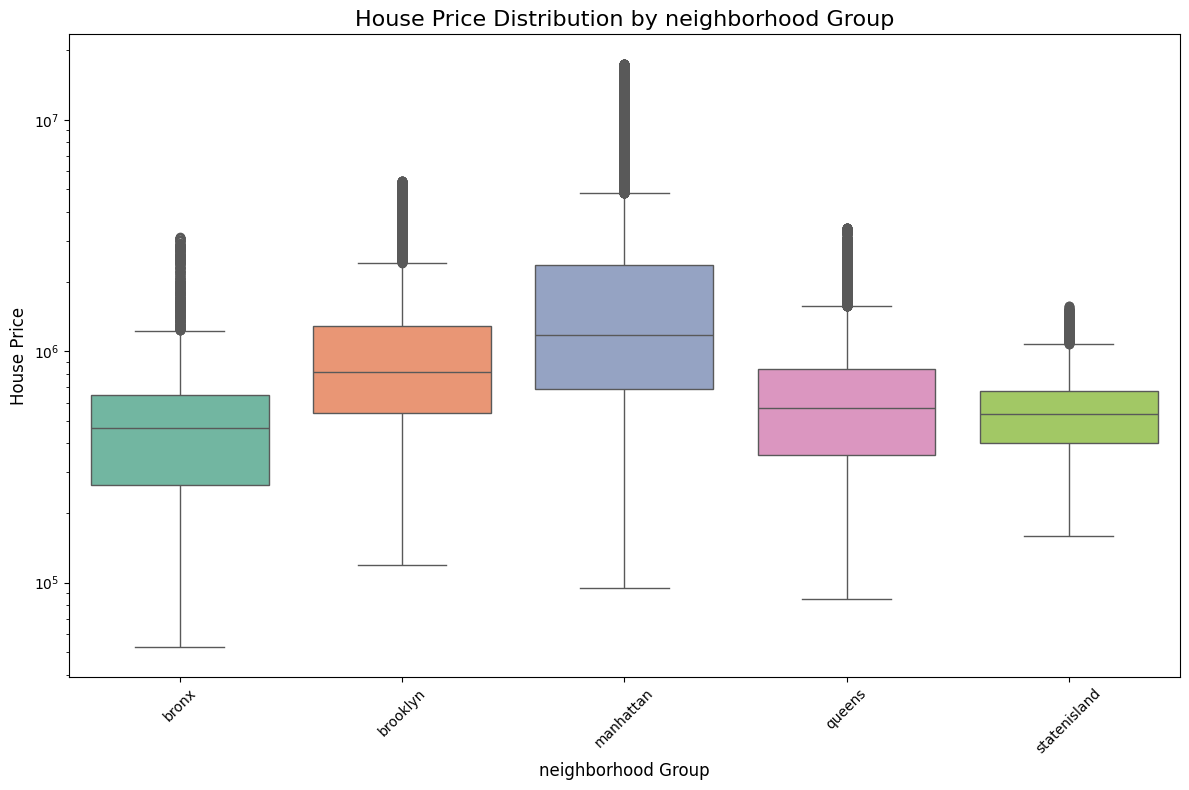

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 설정
plt.figure(figsize=(12, 8))

# 상자 그림(Boxplot) 그리기
sns.boxplot(data=filtered_df, x='neighborhood_group', y='house_price', palette='Set2')

# 그래프 꾸미기
plt.title('House Price Distribution by neighborhood Group', fontsize=16)
plt.xlabel('neighborhood Group', fontsize=12)
plt.ylabel('House Price', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')  # 로그 스케일로 설정 (필요에 따라 제거 가능)
plt.tight_layout()

# 그래프 출력
plt.show()

## neighborhood_group별 평균 가격 구하기

<ipython-input-74-909fd9487f08>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_prices, x='neighborhood_group', y='house_price', palette='viridis')


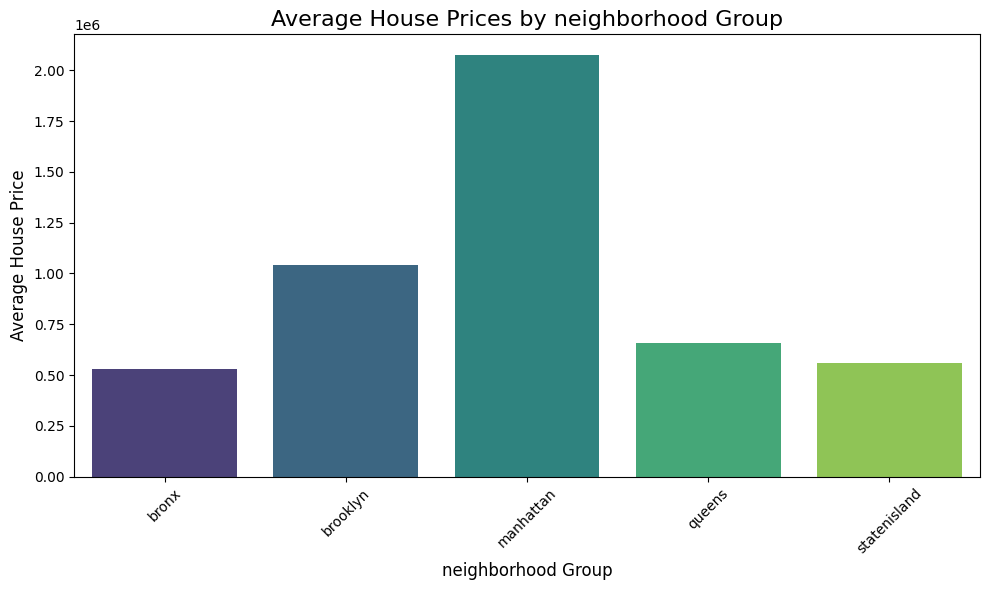

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 지역구별 평균 집 가격 계산
average_prices = filtered_df.groupby('neighborhood_group')['house_price'].mean().reset_index()

# 막대그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(data=average_prices, x='neighborhood_group', y='house_price', palette='viridis')

# 그래프 꾸미기
plt.title('Average House Prices by neighborhood Group', fontsize=16)
plt.xlabel('neighborhood Group', fontsize=12)
plt.ylabel('Average House Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

manhattan이 제일 높고 brooklyn이 두번째 나머지 3개가 적음 → 전처리가 잘 이루어졌다고 판단됨

## neighborhood별 평균 가격 구하기

In [ ]:
# Step 1: neighborhood별 평균 주택 가격 계산
neighborhood_mean_prices = (
    filtered_df.groupby('neighborhood', as_index=False)['house_price'].mean()
)

# Step 2: neighborhood_group 정보 추가
# filtered_df에서 'neighborhood'와 'neighborhood_group'의 고유 조합 추출
neighborhood_group_mapping = filtered_df[['neighborhood', 'neighborhood_group']].drop_duplicates()

# Merge neighborhood_mean_prices와 neighborhood_group_mapping
result_df = pd.merge(neighborhood_mean_prices, neighborhood_group_mapping, on='neighborhood')

# Step 3: 열 이름 변경 및 순서 조정
result_df.rename(columns={'house_price': 'house_price_mean'}, inplace=True)
result_df = result_df[['neighborhood', 'neighborhood_group', 'house_price_mean']]

# 결과 확인
result_df

,neighborhood,neighborhood_group,house_price_mean
0,AIRPORT LA GUARDIA,queens,7.734375e+05
1,ALPHABET CITY,manhattan,1.790824e+06
2,ANNADALE,statenisland,7.538919e+05
3,ARDEN HEIGHTS,statenisland,4.666251e+05
4,ARROCHAR,statenisland,6.190723e+05
...,...,...,...
247,WOODHAVEN,queens,6.762438e+05
248,WOODLAWN,bronx,4.212632e+05
249,WOODROW,statenisland,6.367322e+05
250,WOODSIDE,queens,6.567326e+05


In [ ]:
len(filtered_df['neighborhood'].unique())

251

In [ ]:
# 동일한 neighborhood에 대해 서로 다른 neighborhood_group을 가진 행 찾기
duplicated_neighborhoods = result_df.groupby('neighborhood')['neighborhood_group'].nunique()
inconsistent_neighborhoods = duplicated_neighborhoods[duplicated_neighborhoods > 1].index

# 추출된 neighborhood를 기준으로 데이터 필터링
inconsistent_rows = result_df[result_df['neighborhood'].isin(inconsistent_neighborhoods)]

# 결과 확인
inconsistent_rows

,neighborhood,neighborhood_group,house_price_mean
217,SUNNYSIDE,queens,706456.617571
218,SUNNYSIDE,statenisland,706456.617571


원래 데이터셋에서 neighborhood가 251개로 관측되는데 총 252개의 평균이 구해짐

neighborhood는 동일하지만 다른 neighborhood_group을 가진 데이터가 있는지 확인해보니까 SUNNYSIDE가 queens랑 statenisland에 모두 존재 → 모든 neighborhood별로 평균값이 구해졌음을 확인할 수 있음, 그리고 에어비앤비 데이터와 연결할때 neighborhood와 neighborhood_group 모두 동일한 데이터끼리 연결지어야함!!

## 에어비앤비 숙소 데이터에 neighborhoood별 평균값 추가하기

In [ ]:
# 에어비앤비 숙소 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/ESAA/방학플젝/dataSP25.csv')

In [ ]:
train.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1,Clinton Hill Apartment Single Bedroom ! Pratt ~~,30610258,Santiago,Brooklyn,Clinton Hill,40.69591,-73.96284,Private room,58,2,1,9/23/2018,0.10,1,0
1,2,Andy Phillips,6180052,Andrian,Brooklyn,Fort Greene,40.68769,-73.97490,Private room,99,5,4,9/29/2017,0.17,1,250
2,3,"Stylish, Comfortable, and Affordable in Brooklyn",5957027,Zachary,Brooklyn,Crown Heights,40.67667,-73.91750,Entire home/apt,180,2,126,6/14/2019,3.74,1,74
3,4,15 min train ride to Times Sq and US OPEN,101602599,M,Queens,Woodside,40.74340,-73.90588,Entire home/apt,50,1,95,6/24/2019,5.63,2,0
4,5,Sunny 2 bdrm Park Slope Apt w/ Yard 3min to Su...,106168581,Jason,Brooklyn,South Slope,40.66600,-73.99020,Entire home/apt,210,4,88,7/4/2019,4.41,1,20


In [ ]:
# 열 이름 통일 (neighborhood -> neighbourhood)
result_df.rename(columns={'neighborhood': 'neighbourhood'}, inplace=True)
result_df.rename(columns={'neighborhood_group': 'neighbourhood_group'}, inplace=True)

# 모든 값을 소문자로 변환
train['neighbourhood'] = train['neighbourhood'].str.lower()
train['neighbourhood_group'] = train['neighbourhood_group'].str.lower()

result_df['neighbourhood'] = result_df['neighbourhood'].str.lower()
result_df['neighbourhood_group'] = result_df['neighbourhood_group'].str.lower()

# train 데이터와 result_df를 병합
result = pd.merge(
    train,
    result_df,
    on=['neighbourhood', 'neighbourhood_group'],  # 동일한 neighborhood와 neighborhood_group 기준으로 병합
    how='left'
)

# 결과 출력
print(result)

          id                                               name    host_id  \
0          1   Clinton Hill Apartment Single Bedroom ! Pratt ~~   30610258   
1          2                                      Andy Phillips    6180052   
2          3   Stylish, Comfortable, and Affordable in Brooklyn    5957027   
3          4         15 min train ride to Times Sq and  US OPEN  101602599   
4          5  Sunny 2 bdrm Park Slope Apt w/ Yard 3min to Su...  106168581   
...      ...                                                ...        ...   
27374  27375        Dream home: Beautiful 2B2B Condo in Chelsea  106627653   
27375  27376       Beautiful apartment ~25min from Times Square    6358504   
27376  27377                             Restful Superior Court   51826974   
27377  27378  Private room with a view- cosy apt in East Vil...    5559293   
27378  27379       People of the Arts Welcome! \r\n420 friendly  202986805   

      host_name neighbourhood_group  neighbourhood  latitude  l

In [ ]:
# train과 result_df의 'neighbourhood' 고유값 집합 생성
train_neighbourhood_set = set(train['neighbourhood'].unique())
result_df_neighbourhood_set = set(result_df['neighbourhood'].unique())

# 교집합 구하기
common_neighbourhoods = train_neighbourhood_set & result_df_neighbourhood_set

# 고유값 갯수 출력
print(f"Train 'neighbourhood' unique count: {len(train_neighbourhood_set)}")
print(f"Result_df 'neighbourhood' unique count: {len(result_df_neighbourhood_set)}")
print(f"Common 'neighbourhood' count: {len(common_neighbourhoods)}")

print(f"NaN count for result: {result['house_price_mean'].isna().sum()}")

Train 'neighbourhood' unique count: 215
Result_df 'neighbourhood' unique count: 251
Common 'neighbourhood' count: 136
NaN count for result: 14785
